# 《机器学习》从零开始学(32) 概率图模型专题之精确推断：团树

参考教材：

    1）机器学习-周志华-清华大学出版社-2016  链接:https://pan.baidu.com/s/1c1DSE2W 密码:gufi
    2）概率图模型：原理与技术-[美]D·科勒＆[以色列]N·弗里德曼-王飞跃＆韩素青(译)-清华大学出版社-2015  链接:https://pan.baidu.com/s/1dEBk2rf 密码:77hq

所谓“从零开始”面向的对象其实仅指我本人。也就是我的学习笔记。

**注意**：

1. 此笔记是在我理解基础上的梳理和表述。 

2. 本笔记的代码无法在聚宽上运行，请复制到本地运行(Python2.7，并安装[pgmpy](https://github.com/pgmpy)及其依赖库)。

3. 由于概率图模型有不少难点，所以本笔记不追求自己实现算法，而利用一个冷门库**[pgmpy](http://pgmpy.org/)**作为演练工具（我暂时没有找到更适合的），而具体算法部分可能会从其源代码中截取一段代码做示例。

4. 我隐隐感觉，在**tensorflow**框架下也应该可以实现概率图模型，这方面留到以后研究吧。

团树，简单说就是为模型配置的一个外部数据结构。经过校准后，基于原模型的推理，就变成了基于团树的推理。

## 1）符号约定

我们已经知道，无论是**贝叶斯网**还是**马尔可夫网**，其**联合概率分布**都可以写成因子乘积，区别在于前者已经归一化，而后者需要归一化。 如果不考虑归一化， 因子乘积定义了一个不要求归一化的度量(其归一化就是联合概率分布)：

$$
\tilde{P}_{\Phi}(\mathcal{X}) = \prod_{i=1}^K \phi_i(X_i)
$$

其中：$\mathcal{X}$是**所有变量构成的集合**；$\Phi=\{\phi_1,\dots,\phi_K\}$是**所有因子构成的集合**；$X_i = \mathrm{Scope}[\phi_i]$是因子$\phi_i$的**辖域变量构成的集合**；很明显，$\mathcal{X} = \bigcup_{i=1}^K X_i$。


## 2）聚类图

**聚类图**（cluster graph），提供因子处理过程流程的数据结构。 $\mathcal{X}$上的关于因子集$\Phi$的**聚类图**$\mathcal{U}$是一个无向图：

1） 它的每个节点$i$都有一个**聚类**（变量集）$\mathbf{C}_i \subseteq \mathcal{X}$；

2） 任意因子$\phi_k \in \Phi$只能关联一个**聚类**$\mathbf{C}_i$，记作$ i = \alpha (k)$，并且$\mathrm{Scope}[\phi] \subseteq \mathbf{C}_i$；

3） 任何一对**聚类**$\mathbf{C}_i,\mathbf{C}_j$，这两个**聚类**存在一条**边**，那么这条边与一个**割集**$\mathbf{S}_{i,j} \subseteq \mathbf{C}_i \cap \mathbf{C}_j$关联。

定义**聚类**$\mathbf{C}_i$的所有因子积为$\psi_i$，称之为**聚类因子**：

$$
\psi_i(\mathbf{C}_i) = \prod_{k: \alpha(k)=i} \phi_k  
$$

同时，由于每个因子都恰好指定给一个**聚类**，所以有如下关系：

$$
 \prod_{\phi \in \Phi} \phi  =  \prod_{j} \psi_j
$$


事实上，(31)节的**变量消除算法**就定义了一个聚类图： 

1） 在每步变量消除前，一般会有多个因子相乘得到一个新的因子$\psi_i = \phi_a \phi_b \dots$，这个新因子的辖域是各相乘因子辖域的并集，即$\mathbf{C}_i = \mathrm{Scope}[\psi_i] = \mathrm{Scope}[\phi_a] \cup \mathrm{Scope}[\phi_b] \cup \dots$； 

2） 每个因子（无论新老）只能被用一次，也就意味着每个因子只能关联到一个**聚类**；

3） 每步变量消除后剩余的变量集，如果要继续消除，则需要和另外一个**聚类**有共同要消除的变量，也就是说上一个**聚类**和下一个**聚类**间存在一条变。


比如， 一个简单的**马尔可夫网** （左边），以及一个**聚类图**（右边）:

![简单的马尔可夫网与聚类图](https://jiage.la/upload/201709911052010067080.png)

对于这个简单例子而言， 标记序号的方框代表**聚类**；每个聚类这里都仅有一个因子关联之，则有$\psi_i = \phi_i$；深颜色方框代表传递的**消息**。 以$B \rightarrow 1 \rightarrow A$为例：传入一个消息B给聚类1，然后消除变量A, 最后传出一个消息A。 这个**消息**的辖域就是前面定义中的**割集**。

### 3）团树

上一小节虽然介绍的是更一般的**聚类图**，但给的例子的聚类图是由**变量消除算法诱导出来的**。  事实上，**变量消除**过程中，$\mathbf{C}_i \rightarrow \mathbf{C}_j$发出的**消息**$\tau_i$的**辖域**恰好是$\mathbf{C}_i \cap \mathbf{C}_j$。

这种**边**关联的**割集**恰好等于其相连**聚类交集**（即，$\mathbf{S}_{i,j}= \mathbf{C}_i \cap \mathbf{C}_j$）的性质我们称之为**执行相交性质**(running intersection property)。 而满足**执行相交性质**的聚类图，我们称之为**团树**（也叫：**连接树** 或 **联合树**）。 对应的聚类则被称作**团**。


前面的**聚类因子**，在这里就可叫做**团因子**。

### 4）消息的传递：和积

继续前面的例子，如图：

![消息的传递：和积](https://jiage.la/upload/201709911551395182093.png)

一般而言，从团$\mathbf{C}_i$到$\mathbf{C}_j$所传递的消息可表示成：

$$
\delta_{i \rightarrow j} = \sum_{C_i - S_{i,j}} \psi_i \prod_{k \in (N_i - \{j\})} \delta_{k \rightarrow i}
$$

其中，$N_i$表示$\mathbf{C}_i$邻接团编号的集合。

前面的例子，每个团都仅有一个输入消息一个输出消息。 下面这个例子就存在多个输入消息，一个输出消息。

![存在多个输入单输出的团树](https://jiage.la/upload/201709912211166041605.png)

## 5) 聚类置信、聚类图校准（对团、团树也成立）

根据前面的**消息**的通式，我们可以推导出：

$$
\begin{array}
& \delta_{i \rightarrow j} \delta_{j \rightarrow i} &=& \sum_{C_i - S_{i,j}} \psi_i \prod_{k \in (N_i - \{j\})} \delta_{k \rightarrow i} \delta_{j \rightarrow i} \\
\quad &=& \sum_{C_i - S_{i,j}} \psi_i \prod_{k \in N_i} \delta_{k \rightarrow i} \\
\quad &\overset{\Delta}{=}& \sum_{C_i - S_{i,j}} \beta_i
\end{array}
$$

其中，

$$
\beta_i = \psi_i \prod_{k \in N_i} \delta_{k \rightarrow i}
$$

被称为**聚类**$\mathbf{C}_i$的**置信**（Beliefs）。

另外，根据$\mu_{i,j} = \delta_{i \rightarrow j} \delta_{j \rightarrow i}$的对称性，我们可以推导出：

$$
\mu_{i,j} = \sum_{C_i - S_{i,j}} \beta_i  = \sum_{C_j - S_{i,j}} \beta_j
$$

满足这个条件的两个**聚类**被称作**相互校准的**。 此时$\mu_{i,j}$则被称作**割集置信**。

如果任意两个相邻**聚类**都**相互校准的**，则称这个**聚类图**是**校准的**。


## 6）将校准团树看成一个分布

这是因为（也容易证明）,对校准团树而言：

$$
\tilde{P}_{\Phi}(\mathcal{X}) = \dfrac{\sum_i \beta_i}{\sum_{i,j} \mu_{i,j}}
$$

## 7）消息传递：置信更新

对团$\mathbf{C}_i$到团$\mathbf{C}_j$的所传递的消息$\delta_{i \rightarrow j}$，前面表示成：

$$
\delta_{i \rightarrow j} = \sum_{C_i - S_{i,j}} \psi_i \prod_{k \in (N_i - \{j\})} \delta_{k \rightarrow i}
$$

一旦由了**团置信**$\beta_i$，我们可用另一种方法获得$\mathbf{C}_i \rightarrow \mathbf{C}_j$传递的消息：

$$
\delta_{i \rightarrow j} = \dfrac{\sum_{C_i - S_{i,j}} \beta_i}{\delta_{j \rightarrow i}}
$$

【代码实现往往采用这个方法】

## 8）构建一个团树

前面已经暗示过，按给定顺序的变量消除，会诱导出一个团树。 

基本流程：

1）给定顺序的变量，中间因子$\psi_i$的辖域构成一个团$\mathbf{C}_i$，消除变量后的消息$\tau_i$,则构成下一个中间因子$\psi_j$的边。进而得到一个团树。而这个团树中的团，恰好是给定顺序的变量的**导出图**中的团【笔记(31)】。

2）将团树变成极大团树：即删除被包含的团，最终只保留极大团。被删除团的连线转移到更大的团上。


这种方法被称作**源于变量消除的团树**。

另一种方法就是**源自弦图的团树**，其关键步骤就是**三角剖分**。 【实现代码往往采用源自弦图的团树】

## 9）流程总结，及参考代码

1. 构建模型（贝叶斯网或马尔可夫网）

2. 变量消除的顺序 [参考代码](http://pgmpy.org/_modules/pgmpy/inference/EliminationOrder.html#BaseEliminationOrder.get_elimination_order)

3. 构建团树  [参考代码](http://pgmpy.org/_modules/pgmpy/models/MarkovModel.html#MarkovModel.to_junction_tree)

4. 团树校准  [参考代码](http://pgmpy.org/_modules/pgmpy/inference/ExactInference.html#BeliefPropagation.calibrate)

5. 基于团树的推理 [参考代码](http://pgmpy.org/_modules/pgmpy/inference/ExactInference.html#BeliefPropagation.query)

下面利用pgmpy进行团树推理就更简单了：

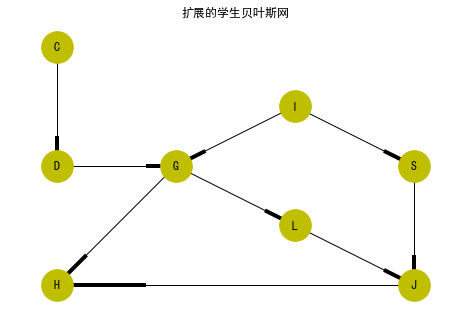

+-----+----------+
| H   |   phi(H) |
|-----+----------|
| H_0 |   0.3180 |
| H_1 |   0.6820 |
+-----+----------+
+-----+----------+
| J   |   phi(J) |
|-----+----------|
| J_0 |   0.2732 |
| J_1 |   0.7268 |
+-----+----------+


In [2]:
import requests
import networkx as nx

from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import BeliefPropagation

import matplotlib.pyplot as plt
%matplotlib inline

def buildBayesianModel(url, show=True):
    '''
            构建有限个离散随机变量的贝叶斯网络
    
    参数：
        url：  已经配置好参数的json文件的网址
        show:  模拟绘制有向图
    '''
    
    r = requests.get(url)
    r.encoding = "GBK"
    param = r.json()

    # 建立贝叶斯网骨架
    model = BayesianModel(param["E"])

    # 添加离散的、概率或条件概率分布表 
    vdata = param["Vdata"]
    for v in vdata:
        cpd = TabularCPD(variable=v, 
                         variable_card=vdata[v]["variable_card"],      
                         values=vdata[v]["values"],
                         evidence=vdata[v]["evidence"],
                         evidence_card=vdata[v]["evidence_card"])
        model.add_cpds(cpd)

    # 验证模型数据的一致性
    if not model.check_model():
        return None
        
    if show:
        # 绘制贝叶斯网的结构
        nx.draw(model, with_labels=True, node_size=1000, font_weight='bold', node_color='y', pos= param["V"])
        plt.title(param["T"])
        plt.show()
    
    return model

'''
    建立扩展的学生贝叶斯网
'''

model = buildBayesianModel("https://jiage.la/upload/201709618010595351319.txt")


'''
    构建团树并进行校准
'''

bp = BeliefPropagation(model)
bp.calibrate()

'''
    基于团树的推理
'''

q = bp.query(variables=['H','J'], evidence={'G':0})
print q['H']
print q['J']